# multiphase/interFoam/laminar/mixerVessel2D


In [1]:
%matplotlib inline
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import vtk
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


In [2]:
import os
files = os.listdir("sample/VTK")
for f in files[:12]:
    print(f)
    
print "--- Rotor ---"
files = os.listdir("sample/VTK/rotor")
for f in files[:3]:
    print(f)
  

back
front
rotor
sample_0.vtk
sample_116.vtk
sample_147.vtk
sample_177.vtk
sample_207.vtk
sample_237.vtk
sample_263.vtk
sample_287.vtk
sample_309.vtk
--- Rotor ---
rotor_0.vtk
rotor_116.vtk
rotor_147.vtk


In [3]:
def getData(filename):
    # load a vtk file as input
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    vtk_arrays= reader.GetOutput().GetPointData()
    #print vtk_nodes
    #print vtk_arrays
    return vtk_arrays

def getNodes(filename):
    # load a vtk file as input
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    points = reader.GetOutput().GetPoints()
    if points is None:
        return None
#    print points
#    Get the coordinates of nodes in the mesh
    nodes_vtk_array= reader.GetOutput().GetPoints().GetData()  
    nodes = vtk_to_numpy(nodes_vtk_array)
    return nodes

In [4]:
# Remove data for z != 0
def extractFlatData(nodes, a, U):
    merged = np.empty([len(nodes),6])
    merged[:,0] = a
    merged[:,1:3] = U[:,:2]
    merged[:,3:] = nodes
    # Merged z0 and z1 arrays should be same because of 
    # the model symmetry along z-axis
    merged_z0 = merged[np.where(merged[:,5] == 0)]
    merged_z1 = merged[np.where(merged[:,5] != 0)]
    # Extract nodes, p and U arrays from z0 array
    a = merged_z0[:,0]
    U = merged_z0[:,1:3]
    nodes = merged_z0[:,3:5]
    return nodes, a, U

# Remove data for |U| == 0 and z != 0
def extractNonzeroData(nodes, a, U):
    merged = np.empty([len(nodes),7])
    print "Extrcting |U|!=0.\na:{} U:{} nodes:{}".format(a.shape, U.shape, nodes.shape)
    merged[:,0] = a
    merged[:,1:3] = U[:,:2]
    merged[:,3:6] = nodes
    # U length squared ^2
    merged[:, 6] = np.power(U[:,0],2) + np.power(U[:,1],2)
    merged_nonzero = merged[np.where(merged[:,6] > 0.01)]
    merged_nonzero = merged_nonzero[np.where(merged_nonzero[:,5] == 0)]
    print "Nonzero matrix shape: {}".format(merged_nonzero.shape)
    # Extract nodes, p and U arrays from z0 array
    a = merged_nonzero[:,0]
    U = merged_nonzero[:,1:3]
    nodes = merged_nonzero[:,3:5]
    return nodes, a, U


In [239]:
# Plot vector field on existing figure
def plotVector_combined(nodes, U, vmin, vmax, filename=""):
    X = nodes[:,0]
    Y = nodes[:,1]
    UN = U[:,0]
    VN = U[:,1]
    stride_elmts = 5
    Xsub = X[::stride_elmts]
    Ysub = Y[::stride_elmts]
    UNsub= UN[::stride_elmts]
    VNsub= VN[::stride_elmts]
    
    plt.quiver(Xsub, Ysub, UNsub, VNsub,        # data                
               np.hypot(UNsub, VNsub),
 #              Usub,                   # colour the arrows based on this array
 #              color='#ffee77',
               cmap=plt.cm.YlOrRd,
               norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax), # Colour range fix
               linewidth=0.5,
               scale=10
               )

    plt.colorbar()                  # adds the colour bar
    
# Plot 2D data on existing figure
def plot2D_combined(nodes, a, vmin, vmax):     
    cdict = {'red': [(0.0, 0.216,0.216),
                     (0.5, 0.99, 0.99),
                     (1.0, 0.5,  0.5)],

         'green': [(0.0,  0.655, 0.655),
                   (0.5,  0.99,   0.99),
                   (1.0,  0.99,  0.99)],

         'blue':  [(0.0,  0.99,  0.99),
                   (0.5,  0.8,   0.8),
                   (1.0,  0.788, 0.788)]}
    mymap = mpl.colors.LinearSegmentedColormap("mymap",cdict)
    color_map = plt.cm.get_cmap('plasma_r')
    limit = 190
    sc = plt.scatter(nodes[:limit,0],nodes[:limit,1],
                     s=2,
                     c = np.linspace(0,1,limit),
                     cmap = color_map,
                     vmin = vmin,
                     vmax = vmax,
                     linewidth=0, 
                     marker="o")
#    plt.colorbar(sc)
 

5.13314999032e-37 - 1.0
A.shape= (6528,)
[ 0.          0.07142857  0.14285714  0.21428571  0.28571429  0.35714286
  0.42857143  0.5         0.57142857  0.64285714  0.71428571  0.78571429
  0.85714286  0.92857143  1.        ]
Extrcting |U|!=0.
a:(6528,) U:(6528, 3) nodes:(6528, 3)
Nonzero matrix shape: (1697, 7)


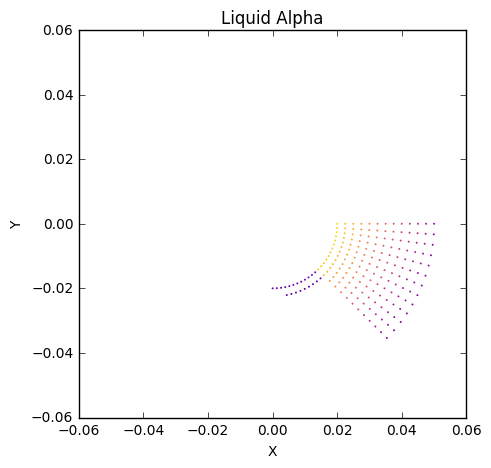

In [240]:
filename = "sample/VTK/sample_287.vtk"
#nodes, p , U   = getData_pvm(filename)
vtk_data = getData(filename)
nodes = getNodes(filename)
p = vtk_to_numpy(vtk_data.GetArray(0))
alpha = vtk_to_numpy(vtk_data.GetArray(1))
p_rgh = vtk_to_numpy(vtk_data.GetArray(2))
U = vtk_to_numpy(vtk_data.GetArray(3))
a = alpha

vmin = np.nanmin(a)
vmax = np.nanmax(a)
print "{} - {}".format(vmin,vmax)
print "A.shape=",a.shape
print np.linspace(0,1,15)

nodes_half, a_half, U_half = extractFlatData(nodes, a, U)
nodes_nonzero, a_nonzero, U_nonzero = extractNonzeroData(nodes, a, U)
# Plot combined figure
plt.figure(figsize=(5,5))
axes = plt.gca()
plt.axis([-.06, .06, -.06, .06])
plt.xlabel('X')
plt.ylabel('Y')


plt.title('Liquid Alpha')
plot2D_combined(nodes_half, a_half, vmin-0.1, vmax+0.2)
# plotVector_combined(nodes_nonzero, U_nonzero, 0, 0.4)

plt.show()

In [234]:
print nodes_half
print nodes_half.shape
print a_half
print a_half.shape

[[ 0.02        0.        ]
 [ 0.0199572  -0.00130806]
 [ 0.0198289  -0.00261052]
 ..., 
 [ 0.0980785   0.019509  ]
 [ 0.0991445   0.0130526 ]
 [ 0.0997859   0.00654031]]
(3264, 2)
[  2.57781010e-15   3.10891991e-14   1.00790002e-13 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]
(3264,)


In [288]:
an = 12 # Number of cells in azimuthal direction
rn = 12 # Number of cells in radius direction

polar_coords = np.zeros(((an+1),(rn+1)),dtype=int)
lin_coords = [0] * nodes_half.shape[0]
print polar_coords.shape
print len(lin_coords)

#polar_coords2 = np.zeros(((an*12),(rn+1)),dtype=int)
s0 = np.arange((an+1)*(rn+1)).reshape((rn+1),(an+1))
polar_coords[:(an+1),:] = s0.transpose()

#print s0
#print s0.shape
#print "- - -"

start_idx = (an+1)*(rn+1)
sectors = 2
for s in range(sectors):
    end_idx = start_idx + (an)*(rn+1)
    s1 = np.arange(start_idx, end_idx).reshape((rn+1),(an))
    print s1.transpose().shape
    polar_coords = np.concatenate((polar_coords, s1.transpose()))

    start_idx = end_idx + 1

    
print polar_coords.shape
#for i in range((acn+1)*(rcn+1)):
#    az = np.mod(i,(acn+1))
#    rd = int(np.floor(i/(acn+1)))
#    lin_coords[i] = [az,rd]
#    polar_coords[az,rd] = i

print polar_coords
print "---"
print "Linear coordinates:"
for i in range(polar_coords.shape[0]):
    for j in range(polar_coords.shape[1]):
        print "{}.{} = {}".format(i,j,polar_coords[i,j])
        lin_coords[polar_coords[i,j]] = [i,j]
        
print "---"
print lin_coords


#    ns = 0 # Use points from next sector    
#    st = np.floor((i)/((acn+1)*(rcn+1))) # sector number
#    az = np.mod(i,(acn+1)) + (st*acn) # point number in row (azimuthal coord)
#    rd = np.floor((i)/(acn+1))+1 # point row number (radial coord)    
#    indexes = [[i,az,rd,st]]
    
#    if (az == 0):
 #       # Use next sector
#        ns = (acn)*(rcn+1)
#    else:
#        ns = 0





(13, 13)
3264
(12, 13)
(12, 13)
(37, 13)
[[  0  13  26  39  52  65  78  91 104 117 130 143 156]
 [  1  14  27  40  53  66  79  92 105 118 131 144 157]
 [  2  15  28  41  54  67  80  93 106 119 132 145 158]
 [  3  16  29  42  55  68  81  94 107 120 133 146 159]
 [  4  17  30  43  56  69  82  95 108 121 134 147 160]
 [  5  18  31  44  57  70  83  96 109 122 135 148 161]
 [  6  19  32  45  58  71  84  97 110 123 136 149 162]
 [  7  20  33  46  59  72  85  98 111 124 137 150 163]
 [  8  21  34  47  60  73  86  99 112 125 138 151 164]
 [  9  22  35  48  61  74  87 100 113 126 139 152 165]
 [ 10  23  36  49  62  75  88 101 114 127 140 153 166]
 [ 11  24  37  50  63  76  89 102 115 128 141 154 167]
 [ 12  25  38  51  64  77  90 103 116 129 142 155 168]
 [169 181 193 205 217 229 241 253 265 277 289 301 313]
 [170 182 194 206 218 230 242 254 266 278 290 302 314]
 [171 183 195 207 219 231 243 255 267 279 291 303 315]
 [172 184 196 208 220 232 244 256 268 280 292 304 316]
 [173 185 197 209 221 23

In [ ]:
# Return 4-cornered poligon point indexes in array nodes_half for given point
def get_polygon_indexes(i):
    az, rz = lin_coords[i]
    print az, rz
    i0 = i
    if rz < polar_coords.shape[1]:
        i1 = polar_coords[az+1,rz]
        i2 = polar_coords[az+1,rz+1]
        i3 = polar_coords[az,rz+1]
        return [i1, i2, i3, i4]
    else
        return None

[[ 155.   12.   12.    0.]
 [ 156.    0.   13.    0.]
 [ 157.    1.   13.    0.]
 [ 158.    2.   13.    0.]
 [ 159.    3.   13.    0.]
 [ 160.    4.   13.    0.]
 [ 161.    5.   13.    0.]
 [ 162.    6.   13.    0.]
 [ 163.    7.   13.    0.]
 [ 164.    8.   13.    0.]
 [ 165.    9.   13.    0.]
 [ 166.   10.   13.    0.]
 [ 167.   11.   13.    0.]
 [ 168.   12.   13.    0.]
 [ 169.   12.   14.    1.]]


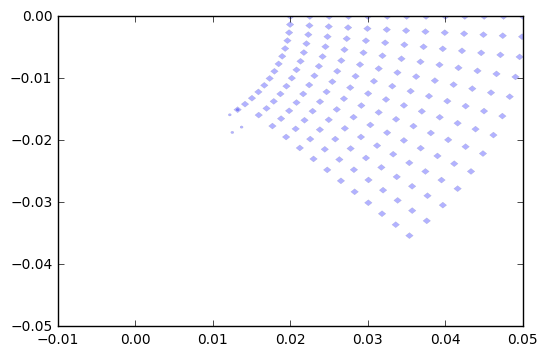

In [232]:
from matplotlib.patches import Polygon, Circle, RegularPolygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots()
patches = []
indexes = [[0,0,0,0]]

N = 170
for i in range(N):
    circle = RegularPolygon(nodes_half[i], 4, 0.0005, ec="none")
    patches.append(circle)
    poly_points = get_polygon_indexes(i)
    if poly_points is None:
        continue
    indexes = np.concatenate((indexes, idx))
    b = np.concatenate((nodes_half[poly_points[0]],
                        nodes_half[poly_points[1]],
                        nodes_half[poly_points[2]],
                        nodes_half[poly_points[3]])).reshape(4,2) 
    #print "B:",b
    #polygon = Polygon(b, True)
    #patches.append(polygon)

for n in range(4):
    try:
        circle = Circle(nodes_half[poly_points[n]], 0.0002, ec="none")
        patches.append(circle)
    except:
        pass
    
print indexes[-15:]

p = PatchCollection(patches, cmap=mpl.cm.plasma_r, alpha=0.3, linewidth=0.1)

colors = a_half[:len(patches)]*1e15
#p.set_array(np.array(colors))

ax.add_collection(p)

ax.set_xlim(-0.01, 0.05)
ax.set_ylim(-0.05, 0.)

plt.show()

In [5]:

vtk_data = getData(filename)
nodes = getNodes(filename)
alpha = vtk_to_numpy(vtk_data.GetArray(1))
U = vtk_to_numpy(vtk_data.GetArray(3))
nodes, a, U = extractFlatData(nodes,alpha,U)

vmin = np.nanmin(a)
vmax = np.nanmax(a)
print "{} - {}".format(vmin,vmax)
print alpha.shape

plot2D(nodes, a, vmin, vmax)


NameError: global name 'vtk' is not defined

In [204]:

vtk_data = getData(filename)
print vtk_data

nodes = getNodes(filename)
print nodes
alpha = vtk_to_numpy(vtk_data.GetArray(1))
U = vtk_to_numpy(vtk_data.GetArray(3))
nodes, a, U = extractFlatData(nodes,alpha,U)

vmin = np.nanmin(a)
vmax = np.nanmax(a)
print "{} - {}".format(vmin,vmax)
print alpha.shape

plot2D(nodes, a, vmin, vmax)



vtkPointData (0x6d06d80)
  Debug: Off
  Modified Time: 37816
  Reference Count: 1
  Registered Events: (none)
  Number Of Arrays: 0
  Number Of Components: 0
  Number Of Tuples: 0
  Copy Tuple Flags: ( 1 1 1 1 1 0 1 1 )
  Interpolate Flags: ( 1 1 1 1 1 0 0 1 )
  Pass Through Flags: ( 1 1 1 1 1 1 1 1 )
  Scalars: (none)
  Vectors: (none)
  Normals: (none)
  TCoords: (none)
  Tensors: (none)
  GlobalIds: (none)
  PedigreeIds: (none)
  EdgeFlag: (none)


None


AttributeError: 'NoneType' object has no attribute 'GetDataType'

In [42]:
def plotVector(X, Y, UN, VN, U, vmin, vmax, filename=""):
    plot1 = plt.figure(figsize=(14,10))
    print U.shape
    stride_elmts = 10
    Xsub = X[::stride_elmts]
    Ysub = Y[::stride_elmts]
    UNsub= UN[::stride_elmts]
    VNsub= VN[::stride_elmts]
    Usub = U[::stride_elmts]
    print Usub.shape
    plt.quiver(Xsub, Ysub, UNsub, VNsub,        # data
               Usub,                   # colour the arrows based on this array
               #cmap=plt.cm.plasma,     # colour map
               norm=mpl.colors.Normalize(vmin=0,vmax=1), # Colour range fix
               
               scale=10
               )

    plt.colorbar()                  # adds the colour bar
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Velocity vector')
    if (filename != ""):
        plot1.tight_layout()
        plt.savefig(filename,bbox_inches='tight')
    else:
        plt.show(plot1)                 # display the plot
    plt.close(plot1)

In [43]:
def plotCombined(X, Y, UN, VN, U, vmin, vmax, a, filename=""):
    plot1 = plt.figure(figsize=(14,10))
    
    print a.shape    
    color_map = plt.cm.get_cmap('plasma')
    axes = plt.gca()
    #axes.set_xlim([-.1,2.1])
    #axes.set_ylim([-.01,0.11])
    #plt.axis('off')
    sc = plt.scatter(X,Y,
                     s=320,
#                     color=cmap(a / a_max),
                     c = a,
                     cmap = color_map,
                     vmin = vmin,
                     vmax = vmax,
                     linewidth=0, 
                     marker="s")
    plt.colorbar(sc)
    #fig.tight_layout()
    print U.shape
    stride_elmts = 10
    Xsub = X[::stride_elmts]
    Ysub = Y[::stride_elmts]
    UNsub= UN[::stride_elmts]
    VNsub= VN[::stride_elmts]
    Usub = U[::stride_elmts]
    print Usub.shape
    plt.quiver(Xsub, Ysub, UNsub, VNsub,        # data
               Usub,                   # colour the arrows based on this array
               #cmap=plt.cm.plasma,     # colour map
               norm=mpl.colors.Normalize(vmin=0,vmax=1), # Colour range fix               
               scale=10
               )

    plt.colorbar()                  # adds the colour bar
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Velocity vector')
    
    
    
    if (filename != ""):
        plot1.tight_layout()
        plt.savefig(filename,bbox_inches='tight')
    else:
        plt.show(plot1)                 # display the plot
    plt.close(plot1)



(0.10040204915044618, 0.39231571849367608)
(3054,)
(306,)


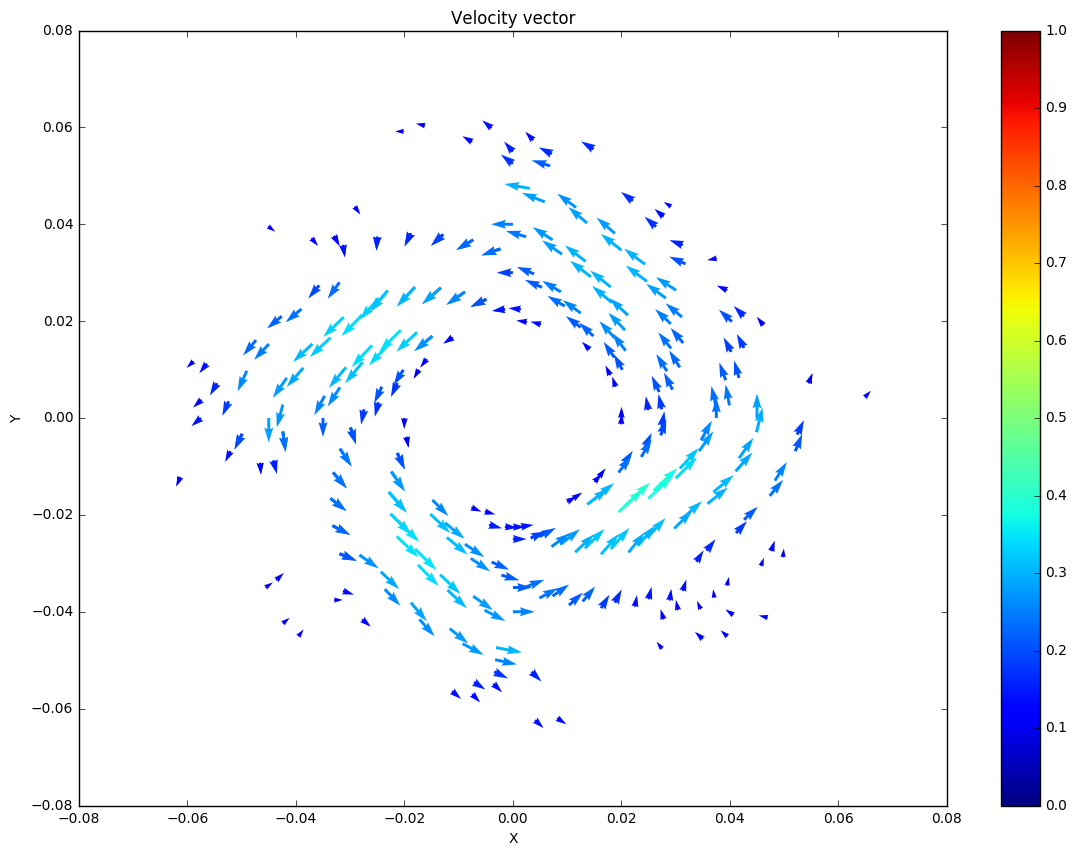

In [215]:
if a_nonzero.size > 0:
    Un_nonzero = np.sqrt(U_nonzero[:,0]**2 + U_nonzero[:,1]**2) #Randomisation:  + np.random.rand(U_half.shape[0])
    print(np.amin(Un_nonzero),np.amax(Un_nonzero))
    plotVector(nodes_nonzero[:,0], nodes_nonzero[:,1], U_nonzero[:,0], U_nonzero[:,1], 
               Un_nonzero, np.amin(Un_nonzero), np.amax(Un_nonzero))

Un half: 0.0 - 0.368021271409
[  0.00000000e+00   5.93944995e-37   4.16211010e-35 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]
(3264,)
(3264,)
(327,)


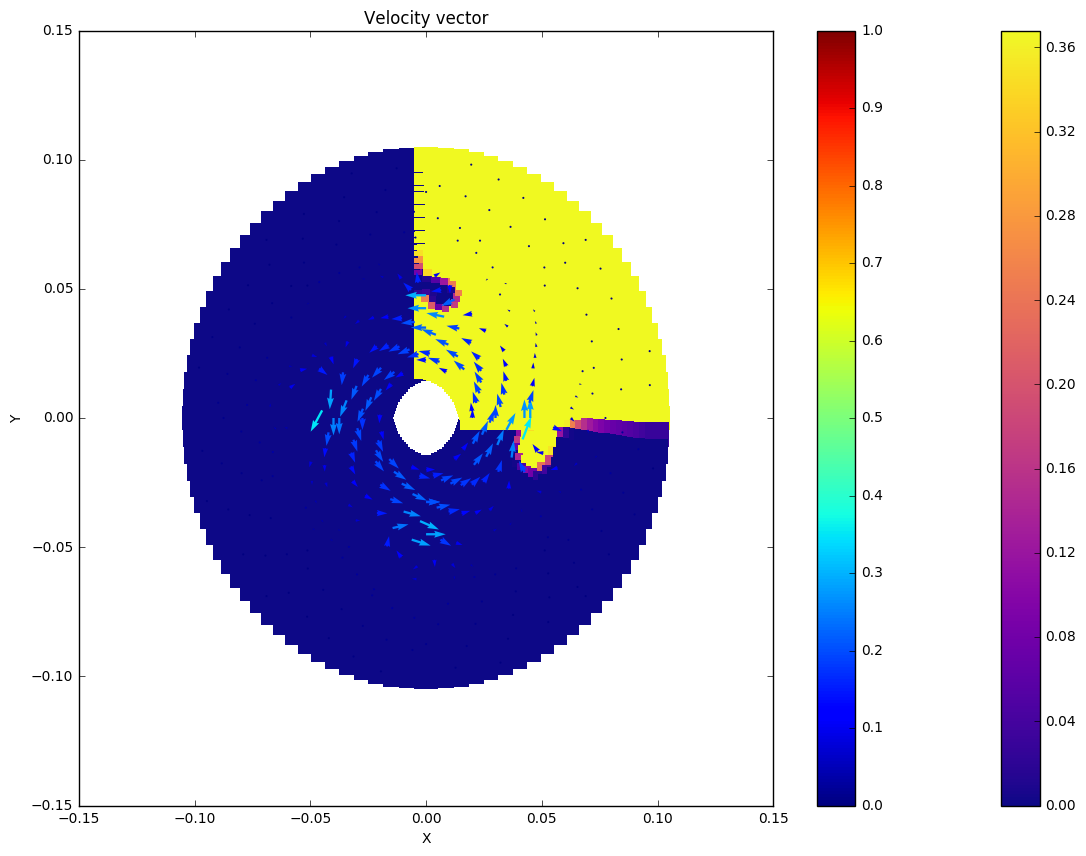

In [51]:
Un_half = np.sqrt(U_half[:,0]**2 + U_half[:,1]**2) #Randomisation:  + np.random.rand(U_half.shape[0])
print"Un half: {} - {}".format(np.amin(Un_half),np.amax(Un_half))
print a
plotCombined(nodes_half[:,0], nodes_half[:,1], U_half[:,0], U_half[:,1], 
               Un_half, np.amin(Un_half), np.amax(Un_half), a_half)

In [22]:
def plot2D(nodes, a, vmin, vmax):     
    # 2d plotting
    fig = plt.figure(figsize=(8,6))
    cmap = mpl.cm.seismic
    color_map = plt.cm.get_cmap('plasma')
    axes = plt.gca()
    #axes.set_xlim([-1.1,1.1])
    #axes.set_ylim([-.01,0.11])
    #plt.axis('off')
    sc = plt.scatter(nodes[:,0],nodes[:,1],
                     s=320,
#                     color=cmap(a / a_max),
                     c = a,
                     cmap = color_map,
                     vmin = vmin,
                     vmax = vmax,
                     linewidth=0, 
                     marker="s")
    plt.colorbar(sc)
    fig.tight_layout()

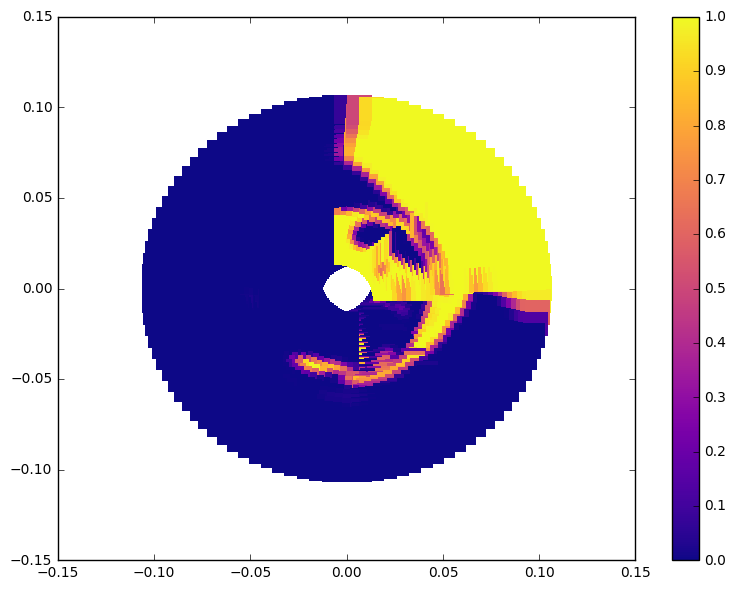

In [23]:

plot2D(nodes_half,a_half, vmin, vmax)

In [178]:
def plot3D(nodes, a, vmin=0, vmax=0):
    print"Shapes: {} {} {}".format(nodes[:,0].shape, nodes[:,1].shape, a.shape)
    color_map = plt.cm.get_cmap('plasma')
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')
    if vmax==0 and vmin==0:
        vmin = np.amin(a)
        vmax = np.amax(a)
    axes = plt.gca()
    axes.set_xlim([-.07,.07])
    axes.set_ylim([-.07,.07])
    axes.set_zlim([-.06,.06])
    splt = ax.scatter(nodes[:,0],nodes[:,1],nodes[:,2],
                      s = 100,
                      c = a,
                      cmap = color_map,
                      vmin = vmin,
                      vmax = vmax,
                      linewidth=0.1,
                      marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    fig.colorbar(splt, shrink=0.5)
    plt.show()